In [4]:
import os
import importlib
import utils
importlib.reload(utils)
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
import matplotlib.pyplot as plt
tf.test.is_built_with_cuda() #GPU aktif mi?

True

In [5]:
print("TensorFlow version:", tf.__version__)
print("GPU Build Info:", tf.sysconfig.get_build_info())
print("GPU Devices:", tf.config.list_physical_devices('GPU'))

# Bellek optimizasyonu (GPU kullanımı için)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Bellek büyümesini sınırla
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)#TensorFlow’un başlangıçta minimum bellek tahsis etmesini ve yalnızca gerektiğinde bellek kullanmasını sağlar.
    except RuntimeError as e:
        print(e)

TensorFlow version: 2.10.1
GPU Build Info: OrderedDict([('cpu_compiler', 'C:/Program Files (x86)/Microsoft Visual Studio/2019/Community/VC/Tools/MSVC/14.29.30133/bin/HostX64/x64/cl.exe'), ('cuda_compute_capabilities', ['sm_35', 'sm_50', 'sm_60', 'sm_70', 'sm_75', 'compute_80']), ('cuda_version', '64_112'), ('cudart_dll_name', 'cudart64_112.dll'), ('cudnn_dll_name', 'cudnn64_8.dll'), ('cudnn_version', '64_8'), ('is_cuda_build', True), ('is_rocm_build', False), ('is_tensorrt_build', False), ('msvcp_dll_names', 'msvcp140.dll,msvcp140_1.dll'), ('nvcuda_dll_name', 'nvcuda.dll')])
GPU Devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [6]:
#Output konsol ayarlamaları
pd.set_option('display.max_columns', None)# Tüm sütunları göster
pd.set_option('display.max_rows', None)# Tüm satırları göster
pd.set_option('display.max_colwidth', None)# Tüm sütun içeriğini gösterir.
pd.set_option("display.float_format", lambda x: '%.3f' % x)# ondalıklı sayıları 3 basamaklı şekilde kısaltır.
pd.set_option('display.width', 5000)# DataFrame oto. alta geçmesin tek satırda gösterilsin diye. 5000 karakter hakkı vardır.

In [7]:
IMG_SIZE = (224, 224)   # Güncellenmiş boyut
EPOCHS = 100 # Modelin veriyi kaç defa işleyecek
ORIGINAL_DATA_PATH = "../TUBITAK/datasets/CSV_Multi_Label_Classification"
AUGMENTED_DATA_PATH = "../TUBITAK/datasets/CSV_Multi_Label_Classification_Augmented"

In [8]:
# Orijinal verileri yükle
original_train_df = utils.load_data('train', base_path=ORIGINAL_DATA_PATH)
original_valid_df = utils.load_data('valid', base_path=ORIGINAL_DATA_PATH)
original_test_df = utils.load_data('test', base_path=ORIGINAL_DATA_PATH)

print("\nOrijinal Veri Seti Dağılımı:")
print(f"Train set: {len(original_train_df)} images")
print(f"Validation set: {len(original_valid_df)} images")
print(f"Test set: {len(original_test_df)} images")

print("\nOrijinal Eğitim Seti Etiket Dağılımı:")
print("Moderate Accident:", original_train_df['moderate'].sum())
print("Severe Accident:", original_train_df['severe'].sum())
print("No Accident:", original_train_df['no_accident'].sum())
print("Multi-label (Moderate & Severe):", ((original_train_df['moderate'] == 1) & (original_train_df['severe'] == 1)).sum())


Orijinal Veri Seti Dağılımı:
Train set: 10469 images
Validation set: 1004 images
Test set: 649 images

Orijinal Eğitim Seti Etiket Dağılımı:
Moderate Accident: 3402
Severe Accident: 6853
No Accident: 259
Multi-label (Moderate & Severe): 45


In [9]:
if not os.path.exists(os.path.join(AUGMENTED_DATA_PATH, 'train', '_classes.csv')):

    # Veri artırımı uygula ve yeni klasöre kaydet
    print("\nVeriler artırılıyor ve yeni dizine kaydediliyor...")
    utils.augment_and_save_data(original_train_df, 'train',
                                no_accident_aug_size=25, moderate_aug_size=1, severe_aug_size=0,
                                output_base_path=AUGMENTED_DATA_PATH)
    utils.augment_and_save_data(original_valid_df, 'valid',
                                no_accident_aug_size=25, moderate_aug_size=1, severe_aug_size=0,
                                output_base_path=AUGMENTED_DATA_PATH)
    utils.augment_and_save_data(original_test_df, 'test',
                                no_accident_aug_size=0, moderate_aug_size=0, severe_aug_size=0,
                                output_base_path=AUGMENTED_DATA_PATH)
else:
    print("Artırılmış veri seti zaten mevcut, mevcut veriler kullanılıyor.")


# Artırılmış veri setini yükle
train_df = utils.load_data('train', base_path=AUGMENTED_DATA_PATH)
valid_df = utils.load_data('valid', base_path=AUGMENTED_DATA_PATH)
test_df = utils.load_data('test', base_path=AUGMENTED_DATA_PATH)

# Tensorflow Dataset'leri oluştur
train_dataset = utils.create_dataset(train_df)
valid_dataset = utils.create_dataset(valid_df)
test_dataset = utils.create_dataset(test_df)

print(f"\nGüncel Train set: {len(train_df)} images")
print(f"Güncel Validation set: {len(valid_df)} images")
print(f"Güncel Test set: {len(test_df)} images")

# Güncel etiket dağılımını kontrol et
print("\nGüncel Eğitim seti etiket dağılımı:")
print("Moderate Accident:", train_df['moderate'].sum())
print("Severe Accident:", train_df['severe'].sum())
print("No Accident:", train_df['no_accident'].sum())
print("Multi-label (Moderate & Severe):", ((train_df['moderate'] == 1) & (train_df['severe'] == 1)).sum())

Artırılmış veri seti zaten mevcut, mevcut veriler kullanılıyor.

Güncel Train set: 16944 images
Güncel Validation set: 1602 images
Güncel Test set: 649 images

Güncel Eğitim seti etiket dağılımı:
Moderate Accident: 3402
Severe Accident: 6853
No Accident: 6734
Multi-label (Moderate & Severe): 45


In [10]:
# Model Mimarisi Oluşturma
def create_model():
    """
    Trafik kazası sınıflandırması için Evrişimli Sinir Ağı (CNN) modelini oluşturur.
    Dropout ve L2 regülarizasyon ile overfitting azaltılmıştır.
    """
    model = models.Sequential([
        # İlk Convolutional blok
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),
                      kernel_regularizer=tf.keras.regularizers.l2(0.002)), # L2 regülarizasyon
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),

        # İkinci Convolutional blok
        layers.Conv2D(64, (3, 3), activation='relu', padding='same',
                      kernel_regularizer=tf.keras.regularizers.l2(0.002)), # L2 regülarizasyon
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),

        # Üçüncü Convolutional blok
        layers.Conv2D(128, (3, 3), activation='relu', padding='same',
                      kernel_regularizer=tf.keras.regularizers.l2(0.002)), # L2 regülarizasyon
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),

        # Sınıflandırma katmanları
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.6),
        layers.Dense(3, activation='softmax') # class_names sayısına göre çıktı katmanı
    ])

    # Model derleme
    model.compile(
        optimizer=optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy'],
    )
    return model

# Model oluştur
model = create_model()

In [11]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',#Doğrulama kaybını izle
        patience=8,#x epoch boyunca iyileşme olmazsa dur
        restore_best_weights=True# En iyi ağırlıklara geri dön
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',# Doğrulama kaybı durursa
        factor=0.5,# Öğrenme oranını %x azalt
        patience=3,# x epoch boyunca iyileşme olmazsa lr düşür
        min_lr=1e-6 # En düşük learningrate oranı
    ),
    tf.keras.callbacks.ModelCheckpoint(
        "best_cnn_model.h5",
        monitor='val_loss',
        save_best_only=True,#en düşük val_loss olduğunda kaydet.
        mode='min',
    )
]

In [12]:
#modeli eğit
history = model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=EPOCHS,
    callbacks=my_callbacks,
    verbose=1
)

Epoch 1/100
530/530 [==============================] - 66s 111ms/step - loss: 1.2714 - accuracy: 0.5822 - val_loss: 2.2917 - val_accuracy: 0.5593 - lr: 0.0010
Epoch 2/100
530/530 [==============================] - 58s 109ms/step - loss: 0.8745 - accuracy: 0.7263 - val_loss: 1.1626 - val_accuracy: 0.6192 - lr: 0.0010
Epoch 3/100
530/530 [==============================] - 57s 108ms/step - loss: 0.7621 - accuracy: 0.7802 - val_loss: 1.1783 - val_accuracy: 0.6592 - lr: 0.0010
Epoch 4/100
530/530 [==============================] - 57s 108ms/step - loss: 0.5690 - accuracy: 0.8555 - val_loss: 8.2744 - val_accuracy: 0.4613 - lr: 0.0010
Epoch 5/100
530/530 [==============================] - 57s 108ms/step - loss: 0.6850 - accuracy: 0.8131 - val_loss: 2.1882 - val_accuracy: 0.4806 - lr: 0.0010
Epoch 6/100
530/530 [==============================] - 58s 109ms/step - loss: 0.5559 - accuracy: 0.8824 - val_loss: 0.9099 - val_accuracy: 0.8215 - lr: 5.0000e-04
Epoch 7/100
530/530 [=====================

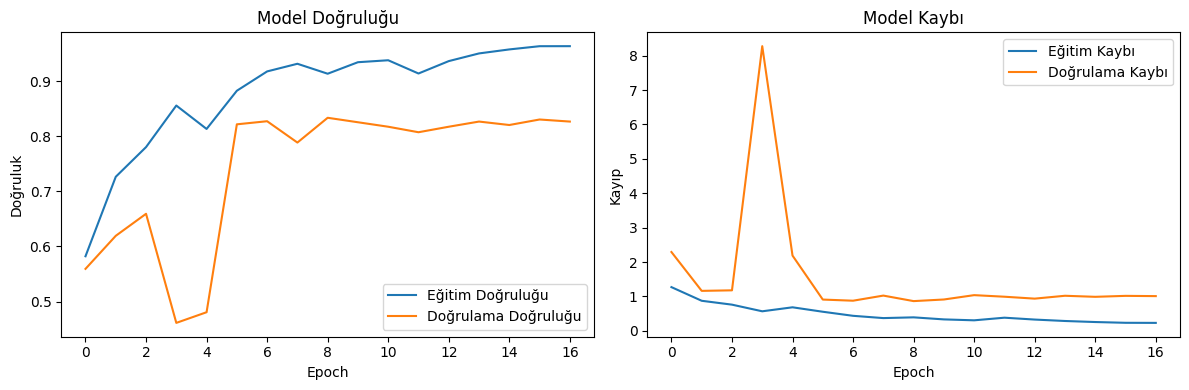

In [13]:
# Eğitim sonuçlarını görselleştir
plt.figure(figsize=(12, 4))#12X4 LÜK GRAFİK PENCERESİ OLUŞTUR.

#Accuracy Greafiği
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
plt.title('Model Doğruluğu')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk')
plt.legend()

#Loss grafiği
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.title('Model Kaybı')
plt.xlabel('Epoch')
plt.ylabel('Kayıp')
plt.legend()

plt.tight_layout()
plt.show()

Accuracy: 0.9137
F1 Score: 0.9271
ROC-AUC Score: 0.9656


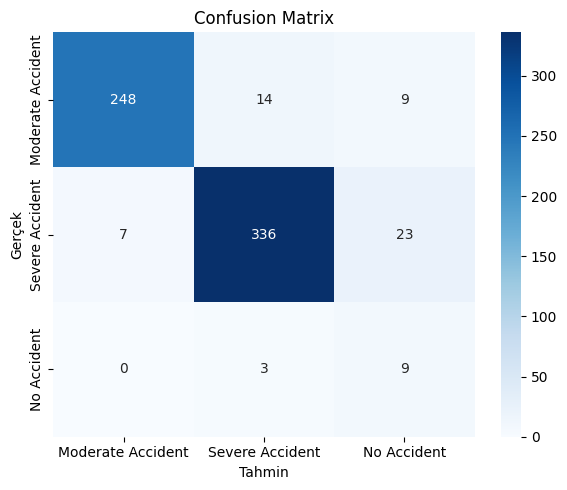


Sınıf Bazlı Performans:
                   precision    recall  f1-score   support

Moderate Accident       0.97      0.92      0.94       271
  Severe Accident       0.95      0.92      0.93       366
      No Accident       0.22      0.75      0.34        12

         accuracy                           0.91       649
        macro avg       0.71      0.86      0.74       649
     weighted avg       0.95      0.91      0.93       649



In [14]:
class_names = ['Moderate Accident', 'Severe Accident', 'No Accident']
utils.evaluate_model(model, test_dataset, class_names)

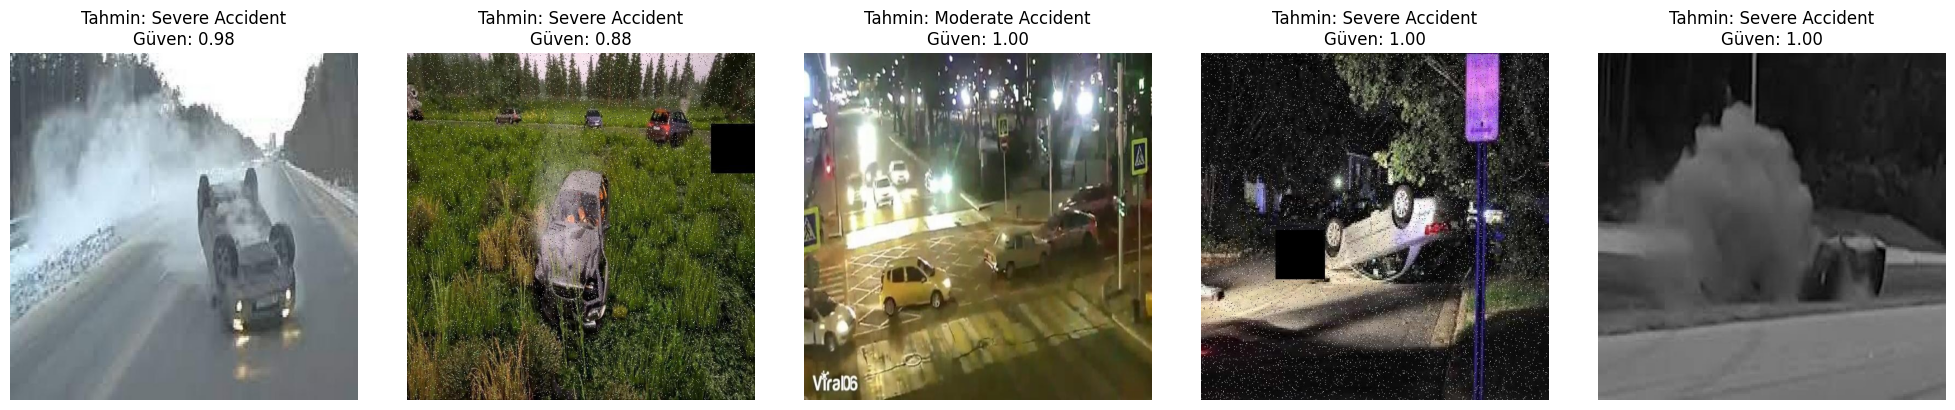

In [15]:
test_image_paths = test_df['filename'].tolist()  # Test seti görüntü yolları
# Tahminlerin görselleştirilmesi
utils.visualize_predictions(
    model=model,
    image_paths=test_image_paths,
    class_names=class_names,
    num_images=5
)